In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Helper import *

In [2]:
#GRAPHS#
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# constants

# 0 - male, 1 - female 
gender = [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, # player 0 - 16
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, # 17 - 32
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, # 33 - 48
         0, 0, 0, 0, 1, 1, 1, 1, 0, 0 ,0 ,0 ] # 49 - 60 

armLength = [24, 28, 28, 28, 28, ]

weightPercentageMale = [0.551, 0.0325, 0.0325, 0.1668, 0.1668, 0.0252, 0.0252]
weightPercentageFemale = [0.532, 0.029, 0.029, 0.1843, 0.1843, 0.0207, 0.0207]

playersTraining = [2, 7, 11, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54]
playersBaseline = [4, 9, 13, 16, 19, 24, 28, 31, 36, 39]
playersOptimal  = [3, 8, 12, 15, 20, 23, 27, 32, 35, 40]

path = "E:\\Andreea\\Master\\Thesis\\Git\\TheOne\\SmartuistWrapper\\tapResultParticipants.csv"

In [28]:
def getStatisticsPhase3(results, players):
    mvmTime = [] 
    gain = []
    efforBodyParts = []
    distBodyParts = []
    for p in players:
        tmp = results[p]
        time = 0
        gain.append(getGainPerPlayer(p, results))
        effort, dist = EffortPerBodyPartPerPlayer(p, results, 10)
        efforBodyParts.append(effort)
        distBodyParts.append(dist)
        for words in tmp:
            time += float(words[10])
        mvmTime.append(time/1000) # time in seconds
    return (mvmTime, gain, efforBodyParts, distBodyParts)

# computes the gain for the player (from effort per body part and throughput)
def getGainPerPlayer(p, results):
    gain = [] 
    batchSize = 10
    nrLessons = 2
    playerResults = results[p]
    
    for l in range(nrLessons):
        stupidTh = 0 
        sumTh = 0
        bodyParts =[ 0 for i in range(7)]
        for res in playerResults: #results for a repetition  
            if(l == int(res[1])):
                for i in range (7):
                    bodyParts[i] += 1 / float(res[21+i])
                sumTh += float(res[13])
                stupidTh += sumTh
        
        bodyParts = [ x / batchSize for x in bodyParts]
        gainEffort = sum(bodyParts) / len(bodyParts)
        gainTh = stupidTh / batchSize
        gain.append((gainEffort + gainTh) / 2)
    
    return np.average(gain)

# get effort and distance per body parts
def EffortPerBodyPartPerPlayer(p, results, batchSize):
    effortBodyParts = [ 0 for i in range(7)]
    distBodyParts = [ 0 for i in range(7)]
    tmp = results[p]
    counter = 0
    for words in tmp:            
        for i in range (7):
            effortBodyParts[i] += float(words[21+i])
            distBodyParts[i] += float(words[14+i])
            
        counter = counter + 1
        if counter == batchSize:
            counter = 0
        if counter == 0:
            for i in range(7):
                effortBodyParts[i] /= batchSize
    return (effortBodyParts, distBodyParts)

# a list with the results at idx for the given player    
def getResultPerPlayer(p, results, idx, unique ):
    tmp = results[p]
    values = []
    for words in tmp:
        values.append(float(words[idx]))
    if (unique == True):
        values =  [x for i, x in enumerate(values) if i == values.index(x)]
    return values

# sort list1 - use the indexes of the sorted list1 to rearrage list2    
def getCombinedPlot(list1, list2):
    idx   = np.argsort(list1)
    list1 = np.array(list1)[idx]
    list2 = np.array(list2)[idx]  
    return (list1, list2)

In [5]:
results = readFromFile(path, 0)
mvmTimeBaseline, gainBaseline, effortBaseline, distBaseline = getStatisticsPhase3(results, playersBaseline)
mvmTimeOptimal, gainOptimal, effortOptimal, distOptimal  = getStatisticsPhase3(results, playersOptimal)

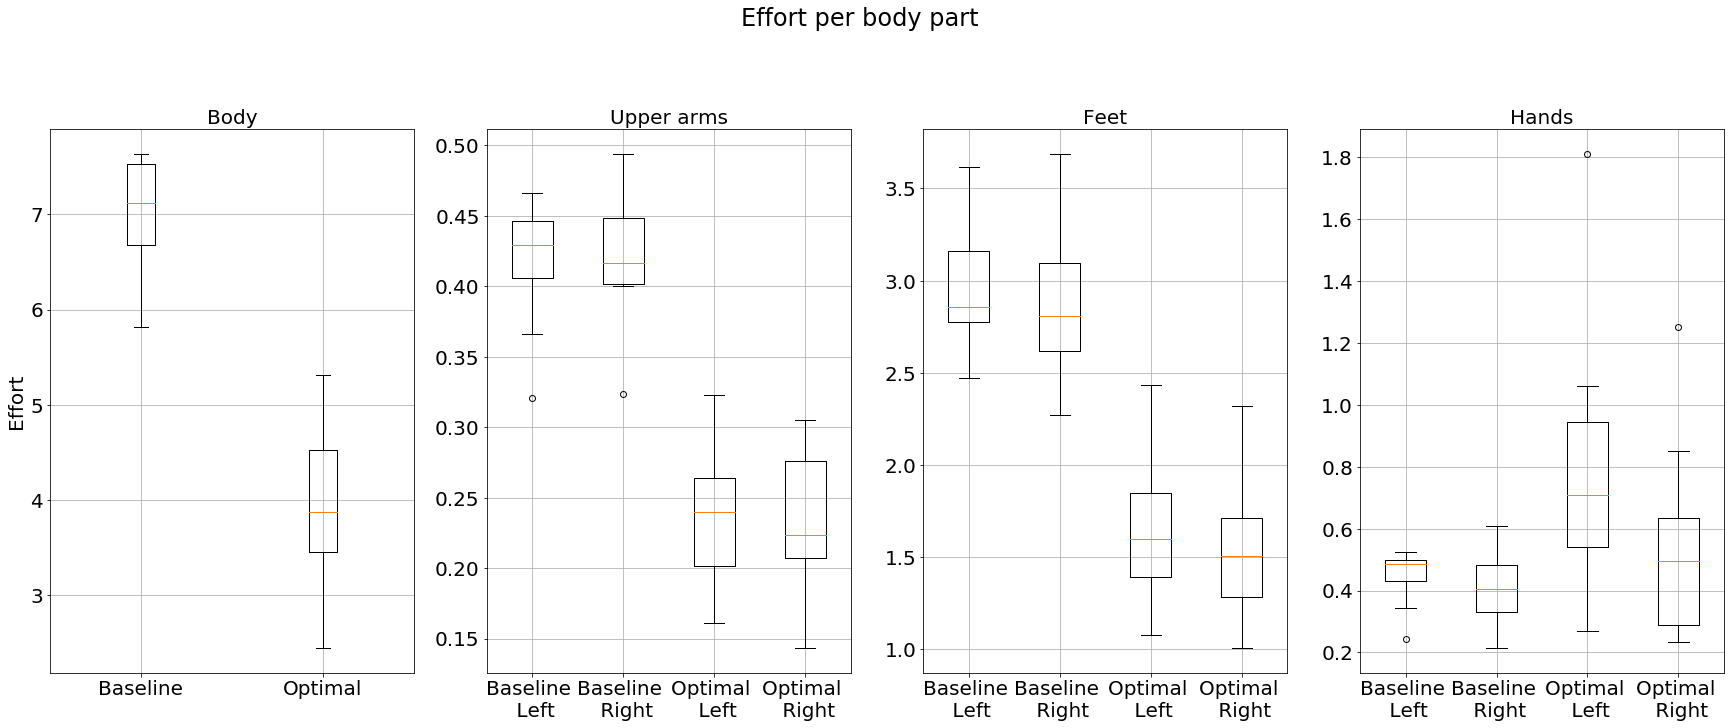

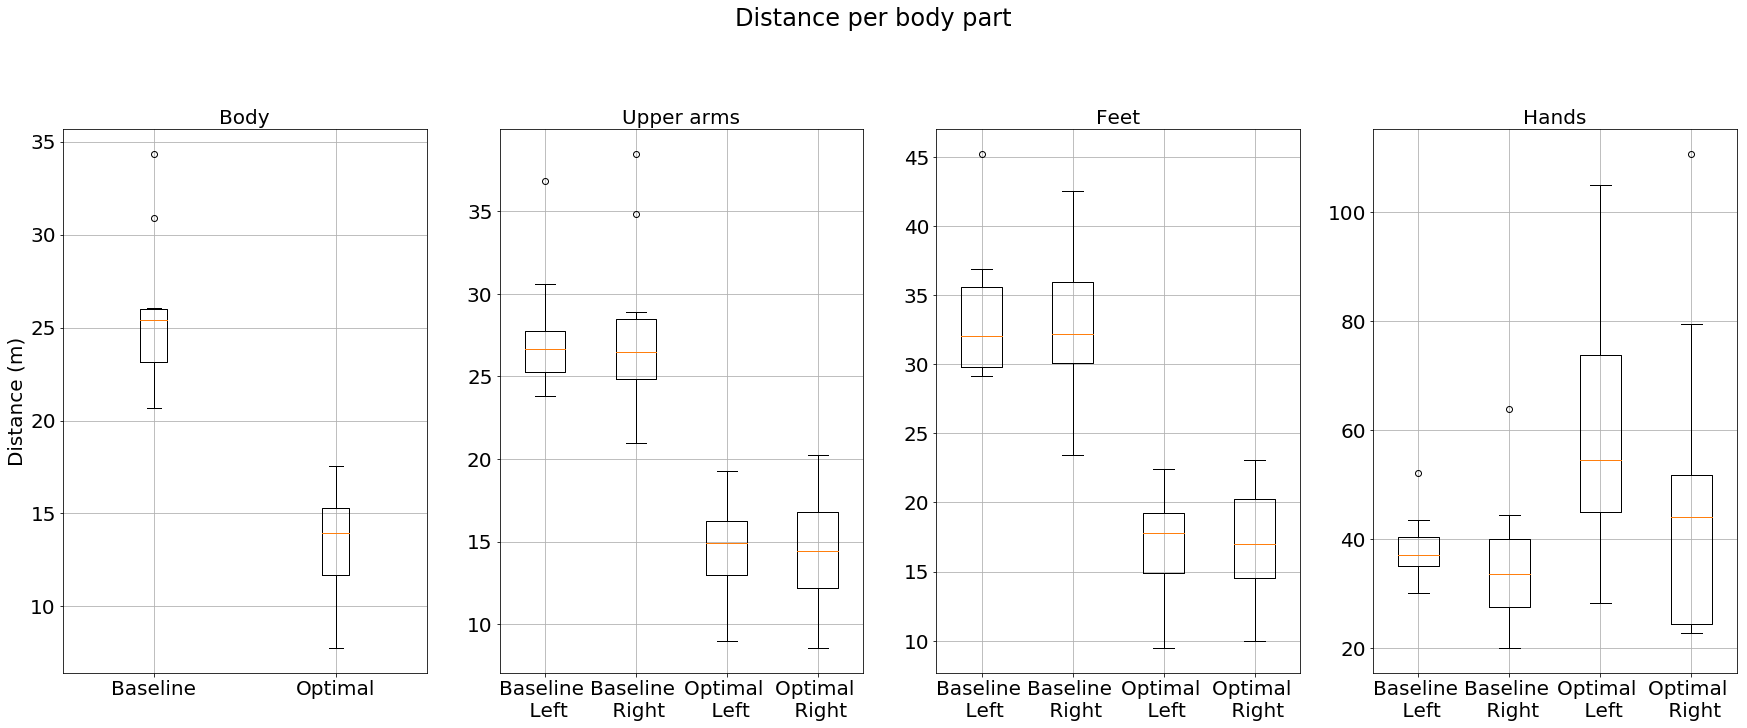

In [6]:
def plotResultsPerBodyPart(baseline, optimal, title, yLabel):
    
    bodyParts = ["Body", "Left Upper Arm", "Right Upper Arm" , "Right Foot" , "Left Foot", "Left Hand" , "Right Hand", ]
    baseline = np.array(baseline)
    optimal = np.array(optimal)

    fig, axs = plt.subplots(ncols = 4, figsize=(30,10))
    fig.suptitle(title, y = 1.05)


    axs[0].boxplot([ baseline[:, 0], optimal[:, 0]], labels= ["Baseline", "Optimal"])
    axs[1].boxplot([ baseline[:, 1], baseline[:, 2], optimal[:,1], optimal[:,2]], 
                   labels= ["Baseline \n Left", "Baseline \n Right", "Optimal \n Left", "Optimal \n Right"])
    axs[2].boxplot([ baseline[:, 4], baseline[:, 3], optimal[:, 4],  optimal[:, 3]],
                   labels= ["Baseline \n Left", "Baseline \n Right", "Optimal \n Left", "Optimal \n Right"])

    axs[3].boxplot([ baseline[:, 5], baseline[:, 6], optimal[:,5], optimal[:,6]], 
                   labels= ["Baseline \n Left", "Baseline \n Right", "Optimal \n Left", "Optimal \n Right" ])


    axs[0].grid(True)
    axs[1].grid(True)
    axs[2].grid(True)
    axs[3].grid(True)
    axs[0].set_ylabel(yLabel)
    axs[0].set_title('Body')
    axs[1].set_title('Upper arms')
    axs[2].set_title('Feet')
    axs[3].set_title('Hands')
    plt.show()

plotResultsPerBodyPart(effortBaseline, effortOptimal, "Effort per body part", "Effort")   
plotResultsPerBodyPart(distBaseline, distOptimal, "Distance per body part", "Distance (m)")    

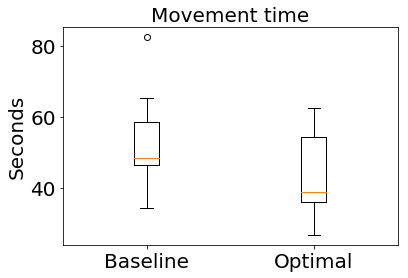

<function matplotlib.pyplot.show(*args, **kw)>

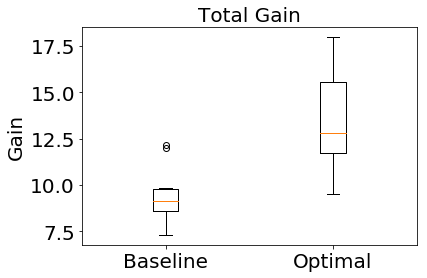

In [7]:
plt.boxplot([mvmTimeBaseline, mvmTimeOptimal], labels= ["Baseline", "Optimal"])
plt.title("Movement time")
plt.ylabel("Seconds")
plt.show()

plt.boxplot([gainBaseline, gainOptimal], labels= ["Baseline", "Optimal"])
plt.title("Total Gain")
plt.ylabel("Gain")
plt.show

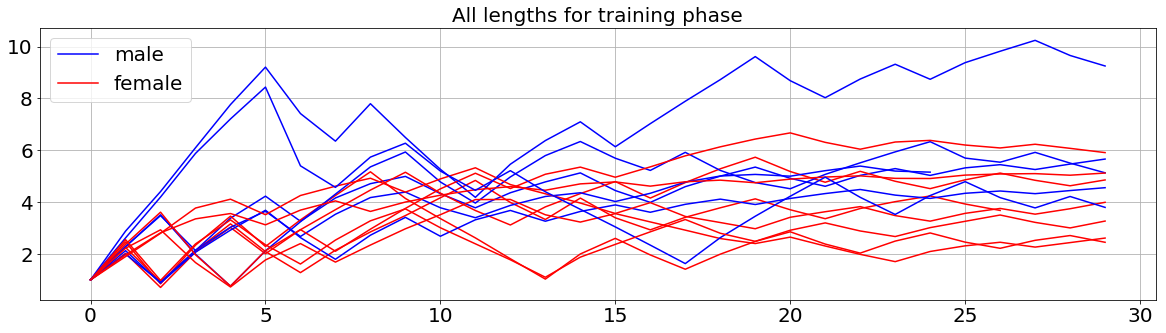

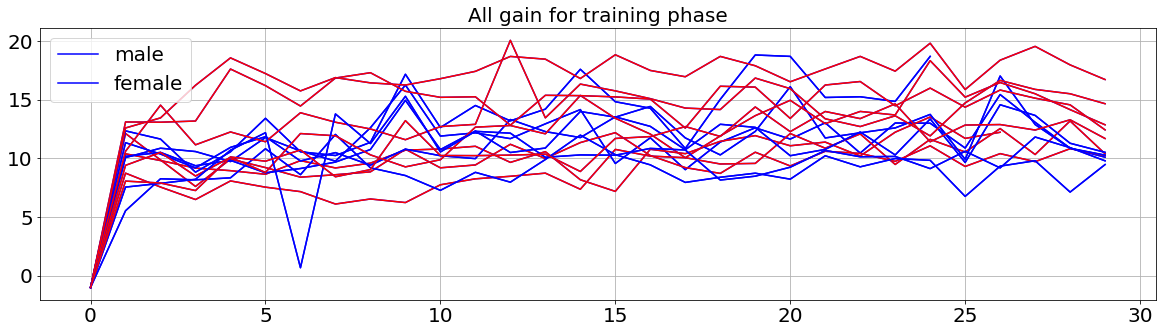

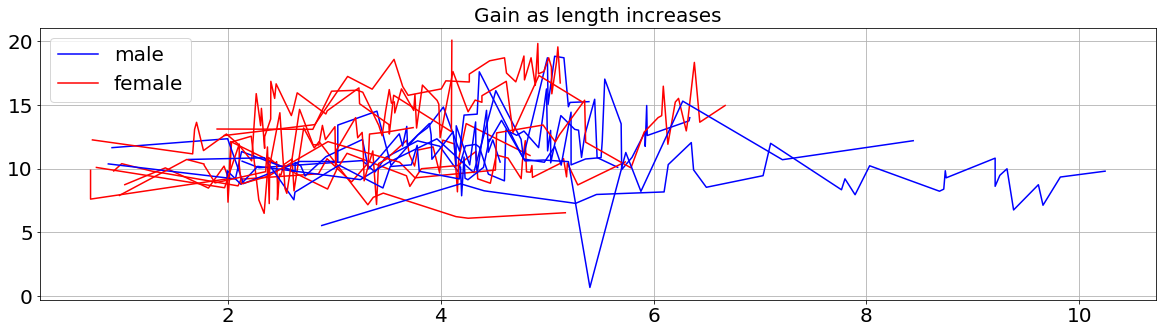

In [38]:
# phase2 results 
plt.rcParams['figure.figsize'] = [20, 5]
lengths = []
gainAllParticipants = [] 
for p in playersTraining:
    lengths.append(getResultPerPlayer(p, results, 28, True ))
    gainAllParticipants.append(getResultPerPlayer(p, results, 29, True ))


for i in range(len(lengths)): # print all lengths 
    l = lengths[i]
    x = list(range(0, len(l)))
    if(gender[playersTraining[i]] == 0):
        plt.plot(x, l, "b")       
    else:
        plt.plot(x, l, "r")

plt.title("All lengths for training phase")
plt.grid(True)
plt.legend(["male", "female"], loc='upper left')
plt.show()

for i in range(len(gainAllParticipants)): 
    l = gainAllParticipants[i]
    x = list(range(0, len(l)))
    plt.plot(x, l, "b")
    if(gender[playersTraining[i]] == 0):
        plt.plot(x, l, "b")       
    else:
        plt.plot(x, l, "r")
    
plt.title("All gain for training phase")
plt.grid(True)
plt.legend(["male", "female"], loc='upper left')
plt.show()

sortedGain = []
sortedLengths = []


#combined plot - gain as length increases 
for i in range(len(gainAllParticipants)): 
    l = lengths[i]
    g = gainAllParticipants[i]
    for j in range(len(l)-1, 1, -1):   
        l[i] = l[i-1]
    (list1, list2) = getCombinedPlot(l[1:], g[1:])
    sortedLengths.append(list1)
    sortedGain.append(list2)
    

for i in range(len(sortedGain)): 
    if(gender[playersTraining[i]] == 0):
        plt.plot(sortedLengths[i], sortedGain[i], "b")       
    else:
        plt.plot(sortedLengths[i], sortedGain[i], "r")
        
plt.title("Gain as length increases")
plt.grid(True)
plt.legend( ["male", "female"], loc='upper left')
plt.show()